In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import xarray as xr
from scipy.signal import periodogram

# Data reading and preprocessing

## Read and visualise the input data

In [24]:
# read data
data_path = "./MMM_test_data.csv"
data = pd.read_csv(data_path, parse_dates=["start_of_week"], dayfirst=True)

data.head()

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,2020-09-06,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


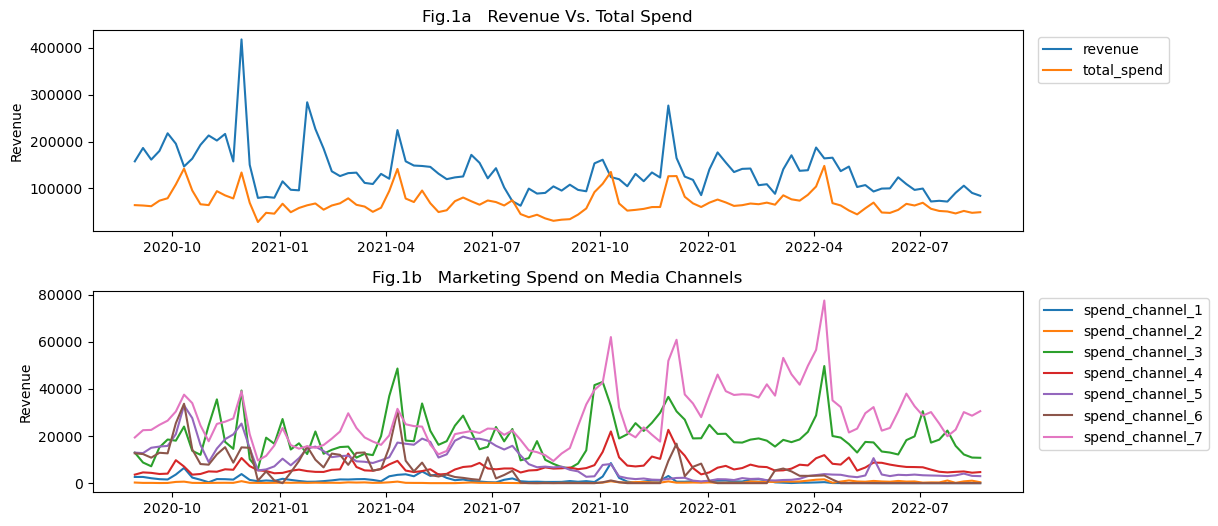

In [27]:
# visualization of data
fig, ax = plt.subplots(2,1, figsize=(12,6))
plt.subplots_adjust(hspace=0.3)
ax[0].plot(data["start_of_week"], data["revenue"], label="revenue")
total_spend = data.drop(columns=["start_of_week", "revenue"]).sum(axis=1)
ax[0].plot(data["start_of_week"], total_spend, label="total_spend")
ax[0].legend(bbox_to_anchor=(1.165, 1))
ax[0].set_title("Fig.1a   Revenue Vs. Total Spend")
ax[0].set_ylabel("Revenue")
ax[1].plot(data["start_of_week"], data[["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", 
                                        "spend_channel_5", "spend_channel_6", "spend_channel_7"]])
ax[1].legend(["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", 
              "spend_channel_5", "spend_channel_6", "spend_channel_7"], bbox_to_anchor=(1.01, 1))
ax[1].set_title("Fig.1b   Marketing Spend on Media Channels")
ax[1].set_ylabel("Revenue")

plt.show()
plt.close()

<font size="4">
Figure 1 above compares: a) the revenue and the total advertising spend, b) spend on different media channels.</br>
</font>

**<font size="4">
Information gained from the plots:</font>** <br>
<font size="4">1. The revenue displays a decreasing trend in the whole period. </font> <br>
<font size="4">2. The revenue displays seasonality: e.g. there was a peak at the end of each November. (Might be caused by the "Black Friday" sales.)</font> <br>
<font size="4">3. The revenue change roughly follows total marketing spend's change, which indicates the effect of advertising is propotional to the cost. </font> <br>
<font size="4">4. Marketing spending varies a lot among channels. Channel 1, 2 have smaller spend comparing to others.</font> <br>
<font size="4">5. Marketing spending of channels have a variance over time, and in some channels (e.g. channel 7) the variance is more significant.</font> <br>

## Data scaling
<br>
<font size="4">
Here I use min-max scaling to preprocess the data. The scaled data are between [0,1], which is in consistent of the non-negative nature of revenue and marketing spend.
</font>

In [25]:
spend_scaler = MinMaxScaler()
data_drop_y = data_date2t.drop(columns=["revenue"]).copy()
data_scaled = pd.DataFrame(spend_scaler.fit_transform(data_drop_y), index=data_drop_y.index, columns=data_drop_y.columns)

revenue_scaler = MinMaxScaler()
revenue_scaled = pd.DataFrame(revenue_scaler.fit_transform(data[["revenue"]]), index=data_drop_y.index, columns=["revenue"])

## Creating Fourier modes for seasonality modelling

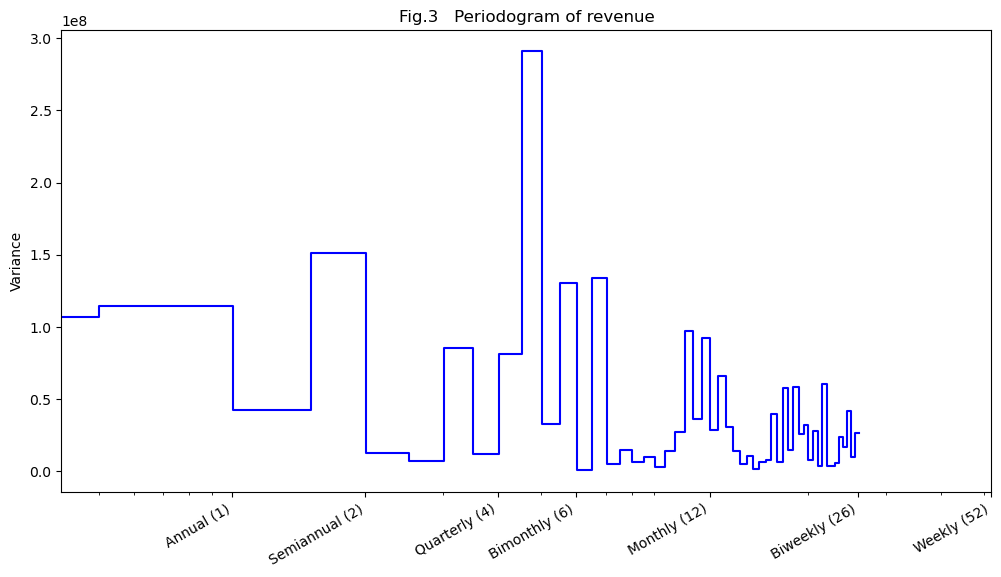

In [6]:
# identify the dominant periods of the revenue time series
def plot_periodogram(ts, detrend='linear', ax=None, title="Periodogram"):
    """Generate the periodogram for weekly time series."""
    fs = pd.Timedelta(days=365.25) / pd.Timedelta(days=7)
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots(figsize=(12,6))
    ax.step(freqencies, spectrum, color="blue")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", "Weekly (52)"],
                       rotation=30, horizontalalignment="right")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title(title)
    return ax

plot_periodogram(data["revenue"], title="Fig.3   Periodogram of revenue")
plt.show()
plt.close()

<font size="4">
    In figure 3, the line drops after period=7. Thus, I decided to include the first 7 fourier modes in my model. </font>

In [26]:
# setting Fourier modes
n_order = 7
periods = data.index / 52
fourier_features = pd.DataFrame(
    {f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
     for order in range(1, n_order + 1)
     for func in ("sin", "cos")}
)

# Models
<br>
<font size="4">
The Bayesian Media Mix Model can be represented as:
$$ y_t = {a + \sum_{m=1}^M \beta_m f(x_{t,m}) + \sum_{c=1}^C \beta_m z_{t,c} + e_t} $$
where ${x_{t,m}}$ denotes predictors, i.e. marketing spend in each channel (transformed by f(x): adstock function, saturation function etc.), <br>
$x_{t,c}$ denotes control variables (trend, seasonality), <br>
$\beta_m$ denotes the coefficients (following the prior distributions), <br>
and $e_t$ denotes the noises. 
</font>

## Base model  -  univariable
<br>
<font size="4">
    As a starting point, I build a model of only one independent variable (spend_channel_1) and no adstock function.
</font>

In [8]:
# model set up
with pm.Model() as base_model:
    # --- coords ---
    base_model.add_coord(name="time", values=data.start_of_week, mutable=True)
    base_model.add_coord(name="fourier_mode", values=np.arange(2 * n_order), mutable=False)
    
    # --- data containers ---
    x_scale = pm.MutableData(name="x_scaled", value=data_scaled.spend_channel_1, dims="time")
    
    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=4)
    ## trend
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=2)
    ## seasonality
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=2, dims="fourier_mode")
    ## regressor
    b_x = pm.HalfNormal(name="b_x", sigma=2)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    ## degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- model parametrization ---
    trend = pm.Deterministic(name="trend", var=a + b_trend * data_scaled.t, dims="time")
    seasonality = pm.Deterministic(name="seasonality", var=pm.math.dot(fourier_features, b_fourier), dims="time")
    x_effect = pm.Deterministic(name="x_effect", var=b_x * x_scale, dims="time")
    mu = pm.Deterministic(name="mu", var=trend + seasonality + x_effect, dims="time")

    # --- likelihood ---
    likelihood = pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=revenue_scaled["revenue"], dims="time")

    # --- prior samples ---
    base_model_prior_predictive = pm.sample_prior_predictive()

Sampling: [a, b_fourier, b_trend, b_x, likelihood, nu, sigma]


In [9]:
# train the model
with base_model:
    base_model_trace = pm.sample(draws=6000, chains=4, idata_kwargs={"log_likelihood": True})
    base_model_posterior_predictive = pm.sample_posterior_predictive(trace=base_model_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_trend, b_fourier, b_x, sigma, nu]


Sampling 4 chains for 1_000 tune and 6_000 draw iterations (4_000 + 24_000 draws total) took 48 seconds.
Sampling: [likelihood]


In [10]:
# print the fitted parameters
az.summary(data=base_model_trace,
           var_names=["a", "b_trend", "b_x", "sigma", "nu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.248,0.024,0.201,0.293,0.000,0.00,15281.0,12403.0,1.0
b_trend,-0.113,0.038,-0.185,-0.041,0.000,0.00,16439.0,13030.0,1.0
b_x,0.054,0.045,0.000,0.134,0.000,0.00,13815.0,13008.0,1.0
sigma,0.087,0.009,0.071,0.103,0.000,0.00,20714.0,14935.0,1.0
nu,10.393,2.286,6.315,14.711,0.014,0.01,25371.0,15362.0,1.0


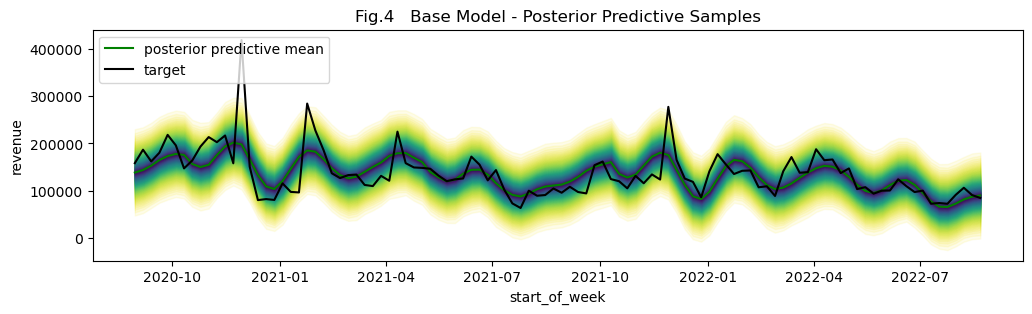

In [11]:
# visual validation of the model
posterior_predictive_likelihood = az.extract(data=base_model_posterior_predictive, group="posterior_predictive", 
                                             var_names="likelihood")
posterior_predictive_likelihood_inv = revenue_scaler.inverse_transform(X=posterior_predictive_likelihood)

# cmap settings
cmap = plt.get_cmap("viridis_r")
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

# plot the predicted revenue and the target values
fig, ax = plt.subplots(figsize=(12,3))
for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(x=data["start_of_week"], y1=upper, y2=lower, color=cmap(color_val), alpha=0.1)
sns.lineplot(x=data["start_of_week"], y=posterior_predictive_likelihood_inv.mean(axis=1), color="green",
             label="posterior predictive mean", ax=ax)
sns.lineplot(x=data["start_of_week"], y=data["revenue"], color="black", label="target", ax=ax)
ax.legend(loc="upper left")
ax.set(title="Fig.4   Base Model - Posterior Predictive Samples")
plt.show()
plt.close()

<font size="4">
Figure 4 shows that the initial model can capture the overall change of the revenue, but it can be further fine-tuned. Now I'll add a adstock function to model the lag effect of advertising spend in the long-term.
</font>

## Adstock_model
<br>
<font size="4">
A commonly used adstock function is the geometric decay adstock function: <br> <br>
    $$ A_t = x_t + \alpha x_{t-1} + \alpha^2 x_{t-2} + ... + \alpha^l x_{t-l}, \;\;\;\; l = 0,1,2,...L $$
    
is applied in this model, where $ A_t $ denotes the transformed marketing spend in a channel at time $t$, <br>
$ x_t $ denotes the marketing spend in the channel at time $t$,<br>
$ \alpha $ denotes the retention rate of ad effect from one time point to the next,<br>
and $ l $ denotes the lag of time.
</font>

In [12]:
def geometric_adstock(x, alpha = 0.0, l_max= 12):
    """Simple geometric decay adstock transformation. The delay of the peak is not considered."""
    cycles = [pt.concatenate([pt.zeros(i), x[: x.shape[0] - i]]) for i in range(l_max)]
    x_cycle = pt.stack(cycles)
    w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])
    return pt.dot(w, x_cycle)

In [13]:
with pm.Model() as adstock_model:
    # --- coords ---
    adstock_model.add_coord(name="time", values=data.start_of_week, mutable=True)
    adstock_model.add_coord(name="fourier_mode", values=np.arange(2 * n_order), mutable=False)
    
    # --- data containers ---
    x1_scale = pm.MutableData(name="x1_scaled", value=data_scaled.spend_channel_1, dims="time")
    x2_scale = pm.MutableData(name="x2_scaled", value=data_scaled.spend_channel_2, dims="time")
    x3_scale = pm.MutableData(name="x3_scaled", value=data_scaled.spend_channel_3, dims="time")
    x4_scale = pm.MutableData(name="x4_scaled", value=data_scaled.spend_channel_4, dims="time")
    x5_scale = pm.MutableData(name="x5_scaled", value=data_scaled.spend_channel_5, dims="time")
    x6_scale = pm.MutableData(name="x6_scaled", value=data_scaled.spend_channel_6, dims="time")
    x7_scale = pm.MutableData(name="x7_scaled", value=data_scaled.spend_channel_7, dims="time")
    
    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=4)
    ## trend
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=2)
    ## seasonality
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=2, dims="fourier_mode")
    ## adstock effect
    alpha1 = pm.Beta(name="alpha1", alpha=1, beta=1)
    alpha2 = pm.Beta(name="alpha2", alpha=1, beta=1)
    alpha3 = pm.Beta(name="alpha3", alpha=1, beta=1)
    alpha4 = pm.Beta(name="alpha4", alpha=1, beta=1)
    alpha5 = pm.Beta(name="alpha5", alpha=1, beta=1)
    alpha6 = pm.Beta(name="alpha6", alpha=1, beta=1)
    alpha7 = pm.Beta(name="alpha7", alpha=1, beta=1)
    ## regressor
    b_x1 = pm.HalfNormal(name="b_x1", sigma=2)
    b_x2 = pm.HalfNormal(name="b_x2", sigma=2)
    b_x3 = pm.HalfNormal(name="b_x3", sigma=2)
    b_x4 = pm.HalfNormal(name="b_x4", sigma=2)
    b_x5 = pm.HalfNormal(name="b_x5", sigma=2)
    b_x6 = pm.HalfNormal(name="b_x6", sigma=2)
    b_x7 = pm.HalfNormal(name="b_x7", sigma=2)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    ## degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- model parametrization ---
    trend = pm.Deterministic(name="trend", var=a + b_trend * data_scaled.t, dims="time")
    seasonality = pm.Deterministic(name="seasonality", var=pm.math.dot(fourier_features, b_fourier), dims="time")
    
    x1_adstock = pm.Deterministic(name="x1_adstock", var=geometric_adstock(x=x1_scale, alpha=alpha1, l_max=12), dims="time")
    x1_effect = pm.Deterministic(name="x1_effect", var=b_x1 * x1_adstock, dims="time")
    x2_adstock = pm.Deterministic(name="x2_adstock", var=geometric_adstock(x=x2_scale, alpha=alpha2, l_max=12), dims="time")
    x2_effect = pm.Deterministic(name="x2_effect", var=b_x2 * x2_adstock, dims="time")
    x3_adstock = pm.Deterministic(name="x3_adstock", var=geometric_adstock(x=x3_scale, alpha=alpha3, l_max=12), dims="time")
    x3_effect = pm.Deterministic(name="x3_effect", var=b_x3 * x3_adstock, dims="time")
    x4_adstock = pm.Deterministic(name="x4_adstock", var=geometric_adstock(x=x4_scale, alpha=alpha4, l_max=12), dims="time")
    x4_effect = pm.Deterministic(name="x4_effect", var=b_x4 * x4_adstock, dims="time")
    x5_adstock = pm.Deterministic(name="x5_adstock", var=geometric_adstock(x=x5_scale, alpha=alpha5, l_max=12), dims="time")
    x5_effect = pm.Deterministic(name="x5_effect", var=b_x5 * x5_adstock, dims="time")
    x6_adstock = pm.Deterministic(name="x6_adstock", var=geometric_adstock(x=x6_scale, alpha=alpha6, l_max=12), dims="time")
    x6_effect = pm.Deterministic(name="x6_effect", var=b_x6 * x6_adstock, dims="time")
    x7_adstock = pm.Deterministic(name="x7_adstock", var=geometric_adstock(x=x7_scale, alpha=alpha7, l_max=12), dims="time")
    x7_effect = pm.Deterministic(name="x7_effect", var=b_x7 * x7_adstock, dims="time")
    mu = pm.Deterministic(name="mu", var=trend + seasonality + x1_effect + x2_effect + x3_effect + x4_effect + x5_effect 
                          + x6_effect + x7_effect, dims="time")

    # --- likelihood ---
    likelihood = pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=revenue_scaled["revenue"], dims="time")

    # --- prior samples ---
    adstock_model_prior_predictive = pm.sample_prior_predictive()

Sampling: [a, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, alpha7, b_fourier, b_trend, b_x1, b_x2, b_x3, b_x4, b_x5, b_x6, b_x7, likelihood, nu, sigma]


In [14]:
# train the model
with adstock_model:
    adstock_model_trace = pm.sample(draws=6000, chains=4, idata_kwargs={"log_likelihood": True})
    adstock_model_posterior_predictive = pm.sample_posterior_predictive(trace=adstock_model_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_trend, b_fourier, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, alpha7, b_x1, b_x2, b_x3, b_x4, b_x5, b_x6, b_x7, sigma, nu]


Sampling 4 chains for 1_000 tune and 6_000 draw iterations (4_000 + 24_000 draws total) took 693 seconds.
Sampling: [likelihood]


In [15]:
# print the fitted parameters
az.summary(data=adstock_model_trace,
           var_names=["a", "b_trend", "b_x1", "b_x2", "b_x3", "b_x4", "b_x5", "b_x6", "b_x7", "alpha1", "alpha2", "alpha3",
                      "alpha4", "alpha5", "alpha6", "alpha7", "sigma", "nu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.022,0.065,-0.099,0.145,0.001,0.001,2190.0,822.0,1.0
b_trend,-0.173,0.091,-0.345,-0.004,0.002,0.001,2971.0,2301.0,1.0
b_x1,0.021,0.020,0.000,0.058,0.000,0.000,11686.0,10534.0,1.0
b_x2,0.061,0.042,0.000,0.136,0.000,0.000,7283.0,8503.0,1.0
b_x3,0.134,0.058,0.020,0.238,0.001,0.001,4781.0,6944.0,1.0
b_x4,0.052,0.045,0.000,0.136,0.000,0.000,8084.0,10532.0,1.0
b_x5,0.053,0.047,0.000,0.138,0.000,0.000,7257.0,8586.0,1.0
b_x6,0.123,0.053,0.017,0.217,0.001,0.001,2296.0,508.0,1.0
b_x7,0.118,0.058,0.020,0.226,0.001,0.001,5251.0,7174.0,1.0
alpha1,0.474,0.290,0.003,0.931,0.003,0.002,9648.0,9524.0,1.0


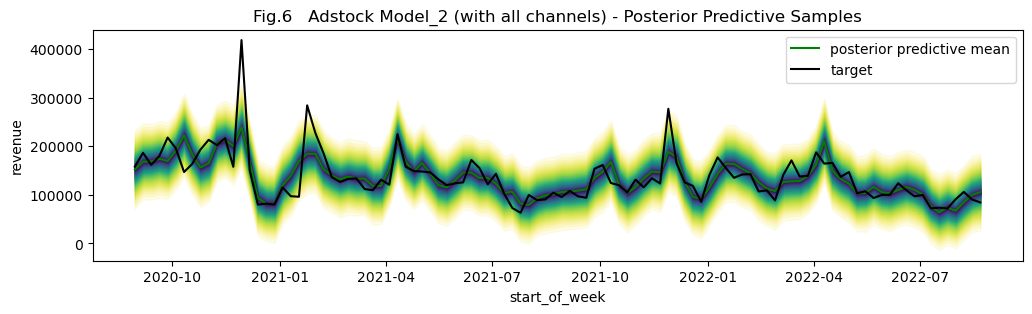

In [16]:
# visual validation of the model
posterior_predictive_likelihood = az.extract(data=adstock_model_posterior_predictive, group="posterior_predictive", 
                                             var_names="likelihood")
posterior_predictive_likelihood_inv = revenue_scaler.inverse_transform(X=posterior_predictive_likelihood)

# plot the predicted revenue and the target values
fig, ax = plt.subplots(figsize=(12,3))
for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(x=data["start_of_week"], y1=upper, y2=lower, color=cmap(color_val), alpha=0.1)
sns.lineplot(x=data["start_of_week"], y=posterior_predictive_likelihood_inv.mean(axis=1), color="green",
             label="posterior predictive mean", ax=ax)
sns.lineplot(x=data["start_of_week"], y=data["revenue"], color="black", label="target", ax=ax)
ax.legend(loc="upper right")
ax.set(title="Fig.6   Adstock Model_2 (with all channels) - Posterior Predictive Samples")
plt.show()
plt.close()

# Model comparison

In [17]:
dataset_dict = {"base_model": base_model_trace, 
                "adstock_model": adstock_model_trace}

az.compare(compare_dict=dataset_dict, ic="loo", method="stacking", scale="log")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
adstock_model,0,94.217875,25.964959,0.000000,0.880356,13.998484,0.000000,False,log
base_model,1,81.919668,18.661405,12.298207,0.119644,13.059326,6.090148,False,log


**<font size="4"> Conclusion: </font>**
<font size="4">
    According to the "rank" column, "adstock_model" has the best performance for the training data.
</font>

# Result analysis of the better model

## Marketing channel effects on the revenue
<br>
<font size="4">
The contributions of each components (trend, seasonality, channel 1~7) and the total revenue are plotted to analyse the effects of each marketing channel. <br>
</font>
Note: the HDI bands of the trend and seasonality contributions are not displayed in the figure 9, so that the contributions of marketing channels can be observed more clearly.

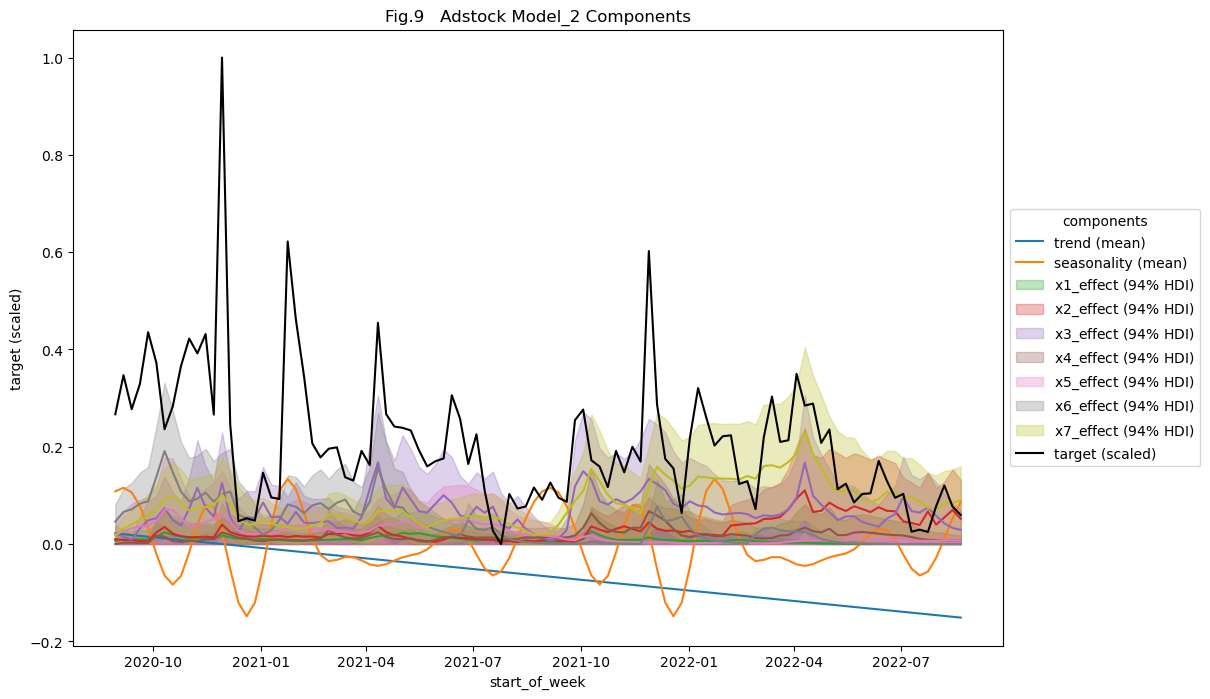

In [19]:
# compute HDI for all the model parameters
model_hdi = az.hdi(ary=adstock_model_trace, hdi_prob=0.94)

# plot the contributions of each components and the total revenue
fig, ax = plt.subplots(figsize=(12,8))
for i, var_effect in enumerate(["trend", "seasonality"]):
    sns.lineplot(x=data["start_of_week"], y=adstock_model_trace.posterior[var_effect].stack(sample=("chain", "draw")).mean(axis=1),
                 color=f"C{i}", label=f"{var_effect} (mean)")
for i, var_effect in enumerate(["x1_effect", "x2_effect", "x3_effect", "x4_effect", "x5_effect", "x6_effect", "x7_effect"]):
    ax.fill_between(x=data["start_of_week"], y1=model_hdi[var_effect][:, 0], y2=model_hdi[var_effect][:, 1], color=f"C{i+2}",
                    alpha=0.3, label=f"{var_effect} ($94\%$ HDI)")
    sns.lineplot(x=data["start_of_week"], y=adstock_model_trace.posterior[var_effect].stack(sample=("chain", "draw")).mean(axis=1),
                 color=f"C{i+2}")
sns.lineplot(x=data["start_of_week"], y=revenue_scaled["revenue"], color="black", alpha=1.0, label="target (scaled)", ax=ax)
ax.legend(title="components", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Fig.9   Adstock Model_2 Components", ylabel="target (scaled)")
plt.show()
plt.close()

**<font size="4">
As we can see from the figure above: </font>** <br>
<font size="4">1.  The investment in channel 7 and 3 earned the most revenue.</font> <br>
<font size="4">2.  Channel 6 is the dominant revenue contributor in the first year, but didn't help much in the second year. According to the raw data, the investment in channel 6 in the second year reduced (even reaching 0 at some time), but the decrease in this channel alone didn't affect the revenue significantly. </font> <br>
<font size="4">3.  The increase of investment in channel 7 brought significant increase of the revenue in the second year.</font> <br>
<font size="4">4.  Channel 2's contribution also increased in the second year, and became one of the dominant revenue-improving marketing channels between 04.2022-08.2022. The seller may consider increase the investment in this channel further.</font>
</font>

## ROI (return on investment) estimates of channels

In [20]:
# extract the trace of the model
adstock_model_trace_roas = adstock_model_trace.copy()

def calculate_ROAS(adstock_model_trace_roas, channel_index):
    adstock_model_roas_numerator = (
        revenue_scaler.inverse_transform(X=az.extract(data=adstock_model_posterior_predictive, group="posterior_predictive", 
                                                      var_names=["likelihood"]))
        - revenue_scaler.inverse_transform(X=az.extract(data=adstock_model_trace_roas, group="posterior_predictive", var_names=["likelihood"]))).sum(axis=0)

    roas_denominator = data["spend_channel_"+str(i)].sum()
    adstock_model_roas = adstock_model_roas_numerator / roas_denominator
    adstock_model_roas_mean = adstock_model_roas.mean()
    adstock_model_roas_hdi = az.hdi(ary=adstock_model_roas)
    return adstock_model_roas_mean, adstock_model_roas_hdi

# Calculate ROAS for each channel
ROAS_channels_adstock_model = pd.DataFrame(columns=["mean", "hdi"])
x_list = ["x1_scaled", "x2_scaled", "x3_scaled", "x4_scaled", "x5_scaled", "x6_scaled", "x7_scaled"]
for i in range(1,8):
    with adstock_model:
        pm.set_data(new_data={x_list[i-1]: np.zeros_like(a=data_scaled["spend_channel_"+str(i)])})
        adstock_model_trace_roas.extend(other=pm.sample_posterior_predictive(trace=adstock_model_trace_roas, var_names=["likelihood"]))
    ROAS_channels_adstock_model.loc[i-1,:] = calculate_ROAS(adstock_model_trace_roas, channel_index=i)
    pm.set_data(new_data={x_list[i-1]: data_scaled["spend_channel_"+str(i)]}, model=adstock_model)

ROAS_channels_adstock_model.index = range(1,8)
ROAS_channels_adstock_model

Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


,mean,hdi
1,2.371445,"[-5.359466888959261, 10.810664159642585]"
2,8.595841,"[-19.426606460616064, 39.18571054891716]"
3,0.151425,"[-0.34222160325479045, 0.6903005275736314]"
4,0.427162,"[-0.9653862220614093, 1.9472955887742522]"
5,0.344452,"[-0.778460844275256, 1.5702454970340962]"
6,0.583345,"[-1.318359893202428, 2.659284279993254]"
7,0.106633,"[-0.2409909094461707, 0.48610651796662163]"


**<font size="4">
Conclusion: 
</font>**
<font size="4">
Channel 2 has the largest ROI: each euro invested in channel 2 brought €8.59 revenue in the studied period. </br>
The seller can consider increasing the investment in channel 2 and 1.
</font>